In [114]:
%run /data/NNDSP/anal/analysis_notebooks/util.ipynb

In [2]:
%run /data/NNDSP/anal/analysis_notebooks/stat_tests.ipynb

## Aseg Feature Importance

This method parses through the aseg file and determines the feature importance of the 66 features via Random Forest. We then randomly permute the entire aseg data dataframe and check its feature importances. We will then determine the cutoff threshold for feature importance.

In [3]:
import pandas as pd

In [4]:
%store -r X_train_sv
%store -r y_train_sv
%store -r X_test_sv
%store -r y_test_sv

### Functions

In [5]:
def feature_importances(rf, X):
    '''
    prints the importance of each feature in X in order of importance
    displays a graph and each feature in order of importance
    
    X = matrix of features
    rf = random forest that was fit on X
    '''
    
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [6]:
def permute_X(X_train_sv):
    '''
    randomly permute all columns of X_train_sv and return the permutaion
    
    X_train_sv = matrix
    '''
    import random
    import pandas as pd 
    
    X_prime = pd.DataFrame([])
    
    # go through all the columns on X_train_sv and shuffle them
    for i in range(X_train_sv.shape[1]):
        x = random.sample((X_train_sv.iloc[:, i].values.T.tolist()), len(X_train_sv))
        X_prime[str(i)] = pd.Series(x)
    
    return X_prime
        

In [7]:
def features_thresh(rf, threshhold):
    '''
    returns a dataframe of all features that have a higher feature importance than threshhold
    
    rf = random forest
    threshhold = float from 0.0 to 1.0
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    features = pd.DataFrame(indices)
    features['importance'] = importances[indices]
    
    features = features[features.importance >= threshhold]
    
    return features

In [8]:
def extract_imp_features(X, features):
    '''
    extract that features from X that are important. The importance is determined by all the features in features. 
    
    X = input data with all the features
    features = dataframe with important features
    '''
    
    return X[features.iloc[:, 0].values.T.tolist()]

### Get Important Features

In [9]:
# get a random permutation of X_train_sv
X_prime = permute_X(X_train_sv)

In [10]:
rf_sv, cv_ = tune_and_train_rf(X_train_sv, y_train_sv.as_matrix().ravel(), target='age') # train random forest on X_train_sv
rf_prime, cv_ = tune_and_train_rf(X_prime, y_train_sv.as_matrix().ravel(), target='age') # train random forest on X_prime

best max_depth: 9
best max_depth: 1


In [11]:
min_thresh = min(list(filter(lambda a: a!=0, rf_prime.feature_importances_))) # remove all zero importance features and choose min from the remaining ones

In [12]:
features = features_thresh(rf_sv, min_thresh) # get all the features more important that min_thresh

### Train on new Features

In [13]:
X_sv = extract_imp_features(X_train_sv, features)

In [14]:
# imputer for missing values
fill_missing = Imputer()
var_thr = VarianceThreshold()
normalize = StandardScaler() # standard nomalizer

# create pipelist for sklearn transformations in order of specification
pipeline_list = [('fill_missing', fill_missing),('var_thr', var_thr),('normalize', normalize)]
    
# SVR regression model
regression_model = SVR(kernel='linear', C=1.0, cache_size=1000)
pipeline_list.append(('regression_model', regression_model))
    
# turn pipeline_list into sklearn Pipeline 
pipe = Pipeline(pipeline_list)

In [15]:
pipe.fit(X=X_sv, y=y_train_sv.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [16]:
# prediction and errors
y_pred_train = pipe.predict(X_sv)
y_pred_test = pipe.predict(extract_imp_features(X_test_sv, features))

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_pred_train))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_pred_test))

from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_pred_cv = cross_val_predict(pipe, X_sv, y_train_sv.as_matrix().ravel())

Mean Absolute Error (Train): 5.55489717138
Mean Absolute Error (Test): 6.03642132057


### Test on HCP

In [17]:
%store -r df_data_hcp_sv

In [18]:
y_pred_hcp_sv = pipe.predict(extract_imp_features(df_data_hcp_sv.iloc[:,:66], features))

In [19]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_data_hcp_sv.Age_in_Yrs, y_pred_hcp_sv))

Mean Absolute Error (HCP): 5.18097354003


### Test on NKI

In [20]:
%store -r df_data_nki_sv

In [21]:
y_pred_nki_sv = pipe.predict(extract_imp_features(df_data_nki_sv.iloc[:,:66], features))

In [22]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_data_nki_sv.age, y_pred_nki_sv))

Mean Absolute Error (HCP): 14.0979248937


## Simple Stacked

In [23]:
%store -r X_train_atf
%store -r X_test_atf
%store -r y_train_atf
%store -r y_test_atf

In [24]:
# pipe for intracranial volume
pipe_inter = pipe_fit(X_train_atf.Intra_Cran_Vol.values.reshape(-1,1), y_train_atf.as_matrix().ravel())

y_predicted_train_inter = pipe_inter.predict(X_train_atf.Intra_Cran_Vol.values.reshape(-1,1))
y_predicted_test_inter = pipe_inter.predict(X_test_atf.Intra_Cran_Vol.values.reshape(-1,1))

In [25]:
# pipe for white matter
pipe_wm = pipe_fit(X_train_atf.WM_Frac.values.reshape(-1,1), y_train_atf.as_matrix().ravel())

y_predicted_train_wm = pipe_wm.predict(X_train_atf.WM_Frac.values.reshape(-1,1))
y_predicted_test_wm = pipe_wm.predict(X_test_atf.WM_Frac.values.reshape(-1,1))

In [26]:
# pipeline for gm only
pipe_gm = pipe_fit(X_train_atf.GM_Frac.values.reshape(-1,1), y_train_atf.as_matrix().ravel())

y_predicted_train_gm = pipe_gm.predict(X_train_atf.GM_Frac.values.reshape(-1,1))
y_predicted_test_gm = pipe_gm.predict(X_test_atf.GM_Frac.values.reshape(-1,1))

In [27]:
# pipeline for csf only
pipe_csf = pipe_fit(X_train_atf.CSF_Frac.values.reshape(-1,1), y_train_atf.as_matrix().ravel())

y_predicted_train_csf = pipe_csf.predict(X_train_atf.CSF_Frac.values.reshape(-1,1))
y_predicted_test_csf = pipe_csf.predict(X_test_atf.CSF_Frac.values.reshape(-1,1))

In [28]:
#put all the predicted train ages into one df
df_simple_stacked = pd.DataFrame([])
df_simple_stacked['Inter'] = y_predicted_train_inter
df_simple_stacked['WM'] = y_predicted_train_wm
df_simple_stacked['GM'] = y_predicted_train_gm
df_simple_stacked['CSF'] = y_predicted_train_csf

# put all the predicted test ages into one df
df_simple_stacked_t = pd.DataFrame([])
df_simple_stacked_t['Inter'] = y_predicted_test_inter
df_simple_stacked_t['WM'] = y_predicted_test_wm
df_simple_stacked_t['GM'] = y_predicted_test_gm
df_simple_stacked_t['CSF'] = y_predicted_test_csf

# Random Forest trained on merged trained predicted ages
rf_ss, cv_res = tune_and_train_rf(df_simple_stacked, y_train_atf.as_matrix().ravel(), target = 'age')

best max_depth: 18


In [29]:
y_predicted_train_ss = rf_ss.predict(df_simple_stacked) # predict for train set
y_predicted_test_ss = rf_ss.predict(df_simple_stacked_t) # predict for test set

print("Mean Absolute Error (Simple Stacked Train):", mean_absolute_error(y_train_atf, y_predicted_train_ss))
print("Mean Absolute Error (Simple Stacked Test):", mean_absolute_error(y_test_atf, y_predicted_test_ss))

Mean Absolute Error (Simple Stacked Train): 2.58750763261
Mean Absolute Error (Simple Stacked Test): 6.39670587555


### Test on HCP

In [30]:
%store -r df_hcp_atf

In [31]:
# get the predictions for each individual feature

# get intercranial volume measurements prediction
y_predicted_hcp_atf_inter = pipe_inter.predict(df_hcp_atf.Intra_Cran_Vol.values.reshape(-1,1))
# get wm prediction
y_predicted_hcp_atf_wm = pipe_wm.predict(df_hcp_atf.WM_Frac.values.reshape(-1,1))
# get gm prediction
y_predicted_hcp_atf_gm = pipe_gm.predict(df_hcp_atf.GM_Frac.values.reshape(-1,1))
# get csf prediction
y_predicted_hcp_atf_csf = pipe_csf.predict(df_hcp_atf.CSF_Frac.values.reshape(-1,1))

In [32]:
# put all predicted values into one df
df_hcp_ss = pd.DataFrame([])
df_hcp_ss['Inter'] = y_predicted_hcp_atf_inter
df_hcp_ss['WM'] = y_predicted_hcp_atf_wm
df_hcp_ss['GM'] = y_predicted_hcp_atf_gm
df_hcp_ss['CSF'] = y_predicted_hcp_atf_csf

# predict ages for HCP using simple stacked
y_predicted_hcp_ss = rf_ss.predict(df_hcp_ss)

In [33]:
print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf_inter))
print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf_wm))
print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf_gm))
print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf_csf))

Mean Absolute Error (HCP): 8.80431400222
Mean Absolute Error (HCP): 13.7296926003
Mean Absolute Error (HCP): 8.83246035619
Mean Absolute Error (HCP): 10.3896503488


In [34]:
# print absolute error for simple stacked
print("Mean Absolute Error Simple Stacked (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_ss))

Mean Absolute Error Simple Stacked (HCP): 10.098074975


In [35]:
%store y_predicted_hcp_ss

Stored 'y_predicted_hcp_ss' (ndarray)


### Test on NKI

In [36]:
%store -r df_nki_atf

In [37]:
# get the predictions for each individual feature

# get intercranial volume measurements prediction
y_predicted_nki_inter = pipe_inter.predict(df_nki_atf.Intra_Cran_Vol.values.reshape(-1,1))
# get wm prediction
y_predicted_nki_wm = pipe_wm.predict(df_nki_atf.WM_Frac.values.reshape(-1,1))
# get gm prediction
y_predicted_nki_gm = pipe_gm.predict(df_nki_atf.GM_Frac.values.reshape(-1,1))
# get csf prediction
y_predicted_nki_csf = pipe_csf.predict(df_nki_atf.CSF_Frac.values.reshape(-1,1))

In [38]:
# put all predicted values into one df
df_nki_ss = pd.DataFrame([])
df_nki_ss['Inter'] = y_predicted_nki_inter
df_nki_ss['WM'] = y_predicted_nki_wm
df_nki_ss['GM'] = y_predicted_nki_gm
df_nki_ss['CSF'] = y_predicted_nki_csf

# predict ages for HCP using simple stacked
y_predicted_nki_ss = rf_ss.predict(df_nki_ss)

In [39]:
print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_inter))
print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_wm))
print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_gm))
print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_csf))

Mean Absolute Error (NKI): 21.9016293092
Mean Absolute Error (NKI): 20.3939480302
Mean Absolute Error (NKI): 18.3130665306
Mean Absolute Error (NKI): 17.8346579649


In [40]:
# print absolute error for simple stacked
print("Mean Absolute Error Simple Stacked (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_ss))

Mean Absolute Error Simple Stacked (NKI): 12.6089661326


In [41]:
%store y_predicted_nki_ss

Stored 'y_predicted_nki_ss' (ndarray)


## Statistical Methods

### Hypothesis 2

In [42]:
%store -r dd_test

#### Aseg Feature Importance

In [43]:
temp_afi = y_test_atf.assign(y_pred = y_pred_test).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_afi.y_pred.values, temp_afi.age_at_scan.values), 
                             np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  9308.0 
 Pvalue:  0.00877421992448 
 Correlation:  0.397166752005


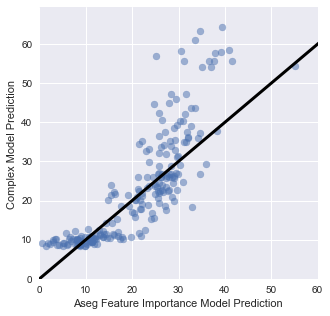

In [44]:
plot_simple_v_complex(temp_afi.y_pred, dd_test.pred_age_test, "", label='Aseg Feature Importance',
                     fig_tuple=(5,5))

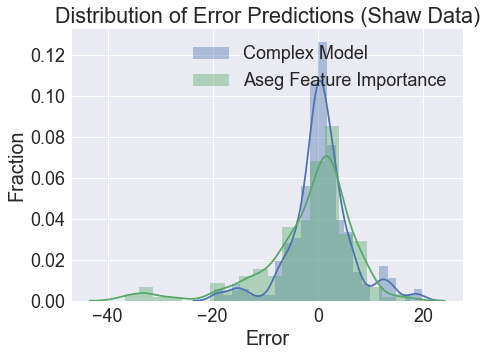

In [45]:
plot_list_ss = {
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
    "Aseg Feature Importance" : np.subtract(temp_afi.y_pred, temp_afi.age_at_scan).values
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (Shaw Data)', set_context='notebook',
            fig_tuple=(7, 5))

#### Simple Stacked

In [46]:
temp_s = y_test_atf.assign(y_pred = y_predicted_test_ss).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_s.y_pred.values, temp_s.age_at_scan.values), 
                             np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  9303.0 
 Pvalue:  0.00863528604554 
 Correlation:  0.396953405018


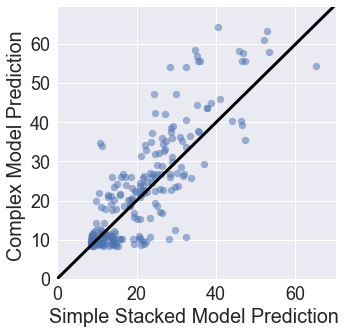

In [47]:
plot_simple_v_complex(temp_s.y_pred, dd_test.pred_age_test, "", label='Simple Stacked',
                     fig_tuple=(5,5))

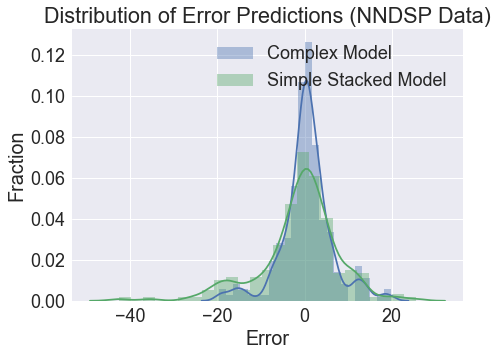

In [48]:
plot_list_ss = {
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
    "Simple Stacked Model" : np.subtract(temp_s.y_pred, temp_s.age_at_scan).values
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (NNDSP Data)', set_context='notebook',
            fig_tuple=(7, 5))

### Hypothesis 3

In [49]:
%store -r df_hcp_pred_data
%store -r df_nki_pred_data

#### HCP Data

##### Simple Stacked Method

In [50]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.SS_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  52722.0 
 Pvalue:  2.50381545529e-81 
 Correlation:  0.131489425379


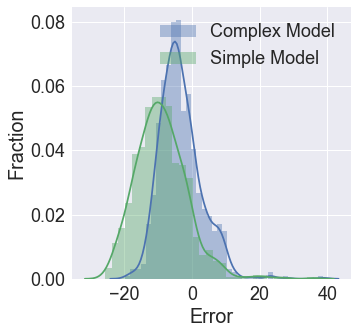

In [51]:
plot_list_hcp_s = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Model" : df_hcp_pred_data.SS_Err
}
plot_ae_hist(plot_list_hcp_s)

##### Aseg Feature Importance

In [52]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.SS_Err, np.subtract(y_pred_hcp_sv, df_hcp_pred_data.Age_in_Yrs))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  35346.0 
 Pvalue:  4.19319610956e-101 
 Correlation:  0.0881534317638


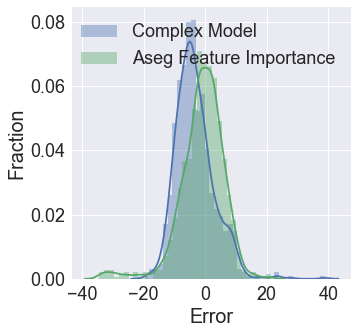

In [53]:
plot_list_hcp_s = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Aseg Feature Importance" : np.subtract(y_pred_hcp_sv, df_hcp_pred_data.Age_in_Yrs)
}
plot_ae_hist(plot_list_hcp_s)

#### NKI Data

##### Simple Stacked Model

In [54]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.SS_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  125140.0 
 Pvalue:  3.51876134639e-21 
 Correlation:  0.317038072944


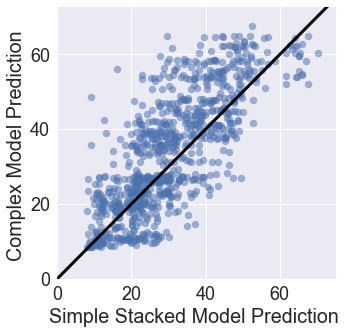

In [55]:
plot_simple_v_complex(df_nki_pred_data.ss_pred, df_nki_pred_data['stack'], title='', 
                      label='Simple Stacked', fig_tuple=(5, 5))

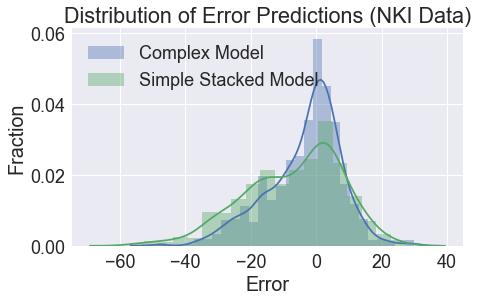

In [56]:
plot_list_nki_s = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Stacked Model" : df_nki_pred_data.SS_Err
}
plot_ae_hist(plot_list_nki_s, title='Distribution of Error Predictions (NKI Data)', set_context='notebook',
            fig_tuple=(7, 4))

##### Aseg Feature Importance

In [57]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.SS_Err, np.subtract(y_pred_nki_sv, df_nki_pred_data.age))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  118007.0 
 Pvalue:  3.08883717687e-25 
 Correlation:  0.298966852116


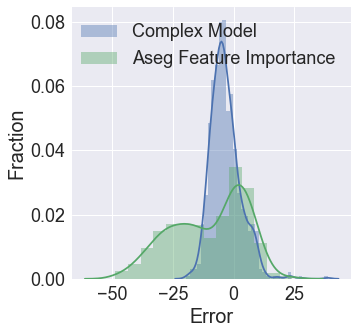

In [58]:
plot_list_hcp_s = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Aseg Feature Importance" : np.subtract(y_pred_nki_sv, df_nki_pred_data.age)
}
plot_ae_hist(plot_list_hcp_s)

## Train on NKI Data

### Extract Data

In [59]:
%store -r df_nki_atf

In [60]:
%store -r nki_features

In [61]:
%store -r df_nki_ages

### Train Complex Model

#### Cortical Thickness

In [62]:
df_data_nki_ct = get_source_data('thickness', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [63]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_nki_ct.iloc[:, :5124], df_data_nki_ct.iloc[:,5125], test_size = 0.5, random_state=None)
# fit model
pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [64]:
# prediction and errors
y_predicted_train_ct = pipe_ct.predict(X_train_ct)
y_predicted_test_ct = pipe_ct.predict(X_test_ct)

In [65]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.0994623341218
Mean Absolute Error (Test): 7.66780664855


In [66]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction 
y_predicted_ct_cv = cross_val_predict(pipe_ct, X_train_ct, y_train_ct)

#### Subcortical Volumnes

In [67]:
df_data_nki_sv = get_source_data('aseg', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [69]:
# Train Test Split
X_train_nki_sv, X_test_nki_sv, y_train_nki_sv, y_test_nki_sv, pipe_nki_sv = train_test_pipeline(df_data_nki_sv.iloc[:, :66], df_data_nki_sv.iloc[:,67], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_nki_sv.fit(X=X_train_nki_sv, y= y_train_nki_sv.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [70]:
# prediction and errors
y_predicted_train_nki_sv = pipe_nki_sv.predict(X_train_nki_sv)
y_predicted_test_nki_sv = pipe_nki_sv.predict(X_test_nki_sv)

In [71]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_nki_sv, y_predicted_train_nki_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_nki_sv, y_predicted_test_nki_sv))

Mean Absolute Error (Train): 6.56779298179
Mean Absolute Error (Test): 8.14623738592


In [72]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_nki_sv_cv = cross_val_predict(pipe_nki_sv, X_train_nki_sv, y_train_nki_sv.as_matrix().ravel())

#### Cortical Surface Area

In [73]:
df_data_nki_ca = get_source_data('area', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [74]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_nki_ca.iloc[:, :5124], df_data_nki_ca.iloc[:,5125], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_ca.fit(X=X_train_ca, y=y_train_ca.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [75]:
# prediction and errors
y_predicted_train_ca = pipe_ca.predict(X_train_ca)
y_predicted_test_ca = pipe_ca.predict(X_test_ca)

In [76]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.099943512096
Mean Absolute Error (Test): 9.09341188961


In [77]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_ca_cv = cross_val_predict(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())

#### Stacked Anatomy

In [79]:
# stack predicted values
# get stacked age predictions (test and train) for ct
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct, first=True)
# get stacked age prediction (test and train) for ca
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
# get stacked age prediction (test and train) for sv
df_y_sv = get_stacked_ages(y_train_nki_sv, y_predicted_train_nki_sv, y_predicted_nki_sv_cv, y_test_nki_sv, y_predicted_test_nki_sv)

In [80]:
# stacking function inputes
target = 'age'

source_dict = {'aseg': df_y_sv, 'ct': df_y_ct,'ca': df_y_ca}

source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

In [81]:
scores_nki_test, dd_nki_train, dd_nki_test, pipe_nki_stack = stacking(source_dict, source_selection_dict, target, show=False)

Fitting stacking model
best max_depth: 4


In [82]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Train):", mean_absolute_error(dd_nki_train.age_at_scan, dd_nki_train.pred_age_train))
print("Mean Absolute Error (Test):", mean_absolute_error(dd_nki_test.age_at_scan, dd_nki_test.pred_age_test))
scores_nki_test

Mean Absolute Error (Train): 4.71108192371
Mean Absolute Error (Test): 5.85052878008


,r2,rpear,rpear2,mae,medae
aseg,0.770199,0.878106,0.771070,8.146237,7.068525
ct,0.794114,0.892000,0.795664,7.667807,6.269289
ca,0.700112,0.837312,0.701092,9.093412,7.216347
mean_pred,0.843493,0.925479,0.856512,6.746697,5.852114
pred_age_test,0.875734,0.936161,0.876398,5.850529,4.406092


### Train Simple Model

In [83]:
X_train_nki_atf, X_test_nki_atf, y_train_nki_atf, y_test_nki_atf, pipe_nki_atf =  train_test_pipeline(df_nki_atf.iloc[:, 4:], 
                                                                                  df_nki_atf.iloc[:, 1], 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
pipe_nki_atf.fit(X=X_train_nki_atf, y=y_train_nki_atf.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [84]:
# prediction and errors
y_pred_train_nki_atf = pipe_nki_atf.predict(X_train_nki_atf)
y_pred_test_nki_atf = pipe_nki_atf.predict(X_test_nki_atf)

In [85]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_nki_atf, y_pred_train_nki_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_nki_atf, y_pred_test_nki_atf))

Mean Absolute Error (Train): 9.8199002102
Mean Absolute Error (Test): 10.3614189297


In [86]:
statistic, pvalue, sum = wilcoxon_sum(np.subtract(y_test_nki_atf.assign(y_pred = y_pred_test_nki_atf).sort_index().y_pred.values, 
                                    y_test_nki_atf.assign(y_pred = y_pred_test_nki_atf).sort_index().age_at_scan.values),
                                       np.subtract(dd_nki_test.pred_age_test, dd_nki_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  36869.0 
 Pvalue:  3.6538971311e-06 
 Correlation:  0.37320579006


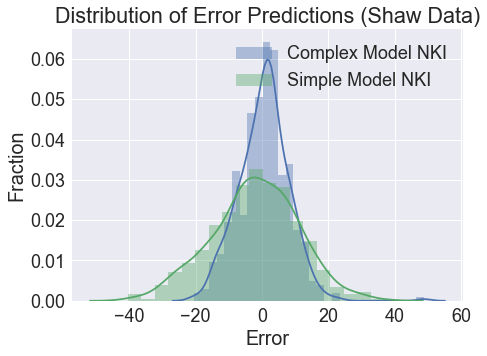

In [87]:
plot_list_ss = {
    "Complex Model NKI" : np.subtract(dd_nki_test.pred_age_test, dd_nki_test.age_at_scan),
    "Simple Model NKI" : np.subtract(y_test_nki_atf.assign(y_pred = y_pred_test_nki_atf).sort_index().y_pred.values, 
                                    y_test_nki_atf.assign(y_pred = y_pred_test_nki_atf).sort_index().age_at_scan.values)
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (Shaw Data)', set_context='notebook',
            fig_tuple=(7, 5))

### Train Simple Stacked Model

In [88]:
pipe_nki_inter = pipe_fit(X_train_nki_atf.Intra_Cran_Vol.values.reshape(-1,1), y_train_nki_atf.as_matrix().ravel())
pipe_nki_wm = pipe_fit(X_train_nki_atf.WM_Frac.values.reshape(-1,1), y_train_nki_atf.as_matrix().ravel())
pipe_nki_gm = pipe_fit(X_train_nki_atf.GM_Frac.values.reshape(-1,1), y_train_nki_atf.as_matrix().ravel())
pipe_nki_csf = pipe_fit(X_train_nki_atf.CSF_Frac.values.reshape(-1,1), y_train_nki_atf.as_matrix().ravel())

In [89]:
#put all the predicted train ages into one df
df_nki_ss = pd.DataFrame([])
df_nki_ss['Inter'] = pipe_nki_inter.predict(X_train_nki_atf.Intra_Cran_Vol.values.reshape(-1,1))
df_nki_ss['WM'] = pipe_nki_wm.predict(X_train_nki_atf.WM_Frac.values.reshape(-1,1))
df_nki_ss['GM'] = pipe_nki_gm.predict(X_train_nki_atf.GM_Frac.values.reshape(-1,1))
df_nki_ss['CSF'] = pipe_nki_csf.predict(X_train_nki_atf.CSF_Frac.values.reshape(-1,1))

# put all the predicted test ages into one df
df_nki_test_ss = pd.DataFrame([])
df_nki_test_ss['Inter'] = pipe_nki_inter.predict(X_test_nki_atf.Intra_Cran_Vol.values.reshape(-1,1))
df_nki_test_ss['WM'] = pipe_nki_wm.predict(X_test_nki_atf.WM_Frac.values.reshape(-1,1))
df_nki_test_ss['GM'] = pipe_nki_gm.predict(X_test_nki_atf.GM_Frac.values.reshape(-1,1))
df_nki_test_ss['CSF'] = pipe_nki_csf.predict(X_test_nki_atf.CSF_Frac.values.reshape(-1,1))

# Random Forest trained on merged trained predicted ages
rf_nki_ss, cv_res = tune_and_train_rf(df_nki_ss, y_train_nki_atf.as_matrix().ravel(), target = 'age')

best max_depth: 8


In [90]:
y_pred_nki_ss = rf_nki_ss.predict(df_nki_ss) # predict for train set
y_pred_test_nki_ss = rf_nki_ss.predict(df_nki_test_ss) # predict for test set

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_nki_atf, y_pred_nki_ss))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_nki_atf, y_pred_test_nki_ss))

Mean Absolute Error (Train): 4.88040930134
Mean Absolute Error (Test): 10.0507268505


In [91]:
statistic, pvalue, sum = wilcoxon_sum(np.subtract(y_test_nki_atf.assign(y_pred = y_pred_test_nki_ss).sort_index().y_pred.values, 
                                    y_test_nki_atf.assign(y_pred = y_pred_test_nki_ss).sort_index().age_at_scan.values),
                                       np.subtract(dd_nki_test.pred_age_test, dd_nki_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  46059.0 
 Pvalue:  0.217526812784 
 Correlation:  0.466231399939


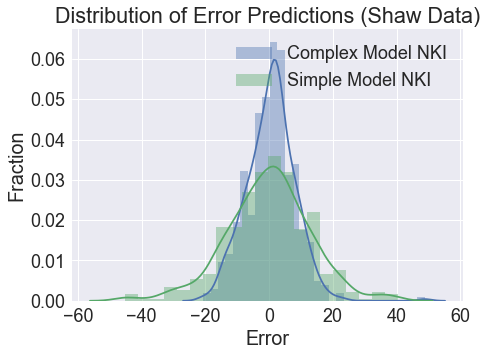

In [92]:
plot_list_ss = {
    "Complex Model NKI" : np.subtract(dd_nki_test.pred_age_test, dd_nki_test.age_at_scan),
    "Simple Model NKI" : np.subtract(y_test_nki_atf.assign(y_pred = y_pred_test_nki_ss).sort_index().y_pred.values, 
                                    y_test_nki_atf.assign(y_pred = y_pred_test_nki_ss).sort_index().age_at_scan.values)
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (Shaw Data)', set_context='notebook',
            fig_tuple=(7, 5))

### Test NNDSP Data

In [93]:
%store -r df_data_ct
%store -r df_data_sv
%store -r df_data_ca

In [95]:
df_nndsp = pd.DataFrame([])
df_nndsp['aseg'] = pipe_nki_sv.predict(df_data_sv.iloc[:, :66])
df_nndsp['ct'] = pipe_ct.predict(df_data_ct.iloc[:, :5124])
df_nndsp['ca'] = pipe_ca.predict(df_data_ca.iloc[:, :5124])
df_nndsp['participant_id'] = df_data_ct.MASKID.values

In [96]:
y_pred_nndsp_stack = pipe_nki_stack.predict(df_nndsp.iloc[:,:3])

In [97]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_data_ct.age_at_scan, y_pred_nndsp_stack))

Mean Absolute Error (NKI): 5.03352043481


In [98]:
%store -r df_atf

In [99]:
y_pred_nndsp_atf = pipe_nki_atf.predict(df_atf.iloc[:, 3:])

In [100]:
print("Mean Absolute Error (HCP):", mean_absolute_error(df_atf.age_at_scan, y_pred_nndsp_atf))

Mean Absolute Error (HCP): 8.08747162144


In [101]:
statistic, pvalue, sum = wilcoxon_sum(np.subtract(y_pred_nndsp_atf, df_atf.age_at_scan),
                                       np.subtract(y_pred_nndsp_stack, df_atf.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  36561.0 
 Pvalue:  0.000113521296473 
 Correlation:  0.392723640113


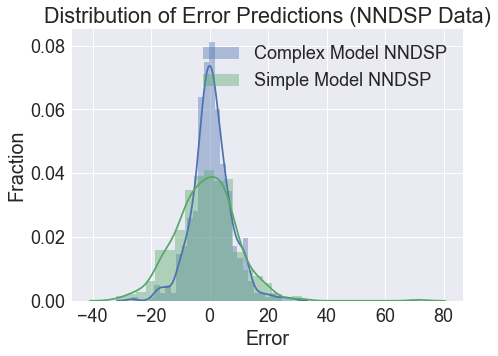

In [102]:
plot_list_ss = {
    "Complex Model NNDSP" : np.subtract(y_pred_nndsp_stack, df_atf.age_at_scan),
    "Simple Model NNDSP" : np.subtract(y_pred_nndsp_atf, df_atf.age_at_scan)
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (NNDSP Data)', set_context='notebook',
            fig_tuple=(7, 5))

In [103]:
df_nndsp_ss = pd.DataFrame([])
df_nndsp_ss['Inter'] = pipe_nki_inter.predict(df_atf.Intra_Cran_Vol.values.reshape(-1,1))
df_nndsp_ss['WM'] = pipe_nki_wm.predict(df_atf.WM_Frac.values.reshape(-1,1))
df_nndsp_ss['GM'] = pipe_nki_gm.predict(df_atf.GM_Frac.values.reshape(-1,1))
df_nndsp_ss['CSF'] = pipe_nki_csf.predict(df_atf.CSF_Frac.values.reshape(-1,1))

In [104]:
y_pred_nndsp_ss = rf_nki_ss.predict(df_nndsp_ss)

print("Mean Absolute Error (Train):", mean_absolute_error(df_atf.age_at_scan, y_pred_nndsp_ss))

Mean Absolute Error (Train): 7.86485513388


In [105]:
statistic, pvalue, sum = wilcoxon_sum(np.subtract(y_pred_nndsp_ss, df_atf.age_at_scan),
                                       np.subtract(y_pred_nndsp_stack, df_atf.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  34656.0 
 Pvalue:  4.30796874494e-06 
 Correlation:  0.372260891982


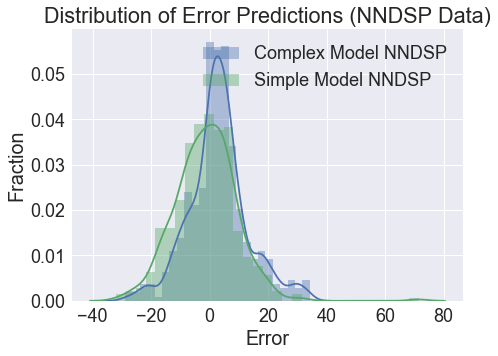

In [106]:
plot_list_ss = {
    "Complex Model NNDSP" : np.subtract(y_pred_nndsp_ss, df_atf.age_at_scan),
    "Simple Model NNDSP" : np.subtract(y_pred_nndsp_atf, df_atf.age_at_scan)
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (NNDSP Data)', set_context='notebook',
            fig_tuple=(7, 5))

## HCP Age Range

In [107]:
min_hcp_age = min(df_hcp_atf.Age_in_Yrs)
max_hcp_age = max(df_hcp_atf.Age_in_Yrs)

In [108]:
df_hrange = pd.DataFrame([])
df_hrange = df_nki_pred_data[df_nki_pred_data.age >= min_hcp_age]
df_hrange = df_hrange[df_hrange.age <= max_hcp_age]

In [109]:
print("Mean Absolute Error (Complex):", mean_absolute_error(df_hrange.age, df_hrange['stack']))
print("Mean Absolute Error (Simple):", mean_absolute_error(df_hrange.age, df_hrange.atf_pred))
print("Mean Absolute Error (Simple Stacked):", mean_absolute_error(df_hrange.age, df_hrange.ss_pred))

Mean Absolute Error (Complex): 5.2757921409
Mean Absolute Error (Simple): 5.50026537553
Mean Absolute Error (Simple Stacked): 6.63395127578


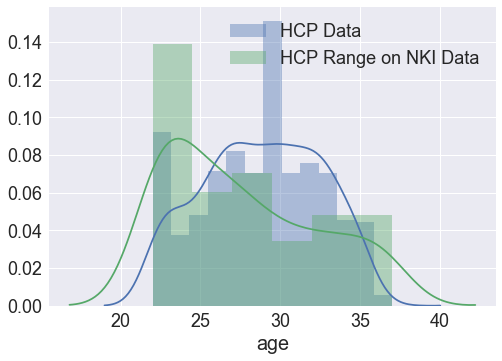

In [110]:
sns.distplot(df_hcp_atf.Age_in_Yrs, label='HCP Data')
sns.distplot(df_hrange.age, label= 'HCP Range on NKI Data')
plt.legend(loc='best')
plt.show()

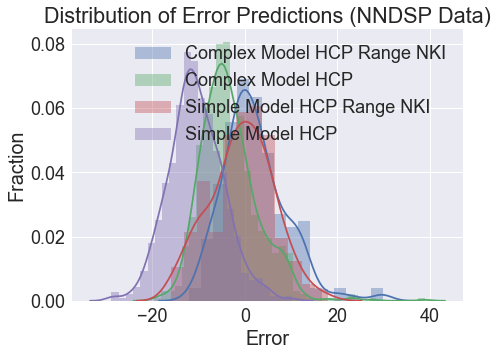

In [111]:
plot_list_ss = {
    "Complex Model HCP Range NKI" : np.subtract(df_hrange['stack'], df_hrange.age),
    "Complex Model HCP" : df_hcp_pred_data.Complx_Err,    
    "Simple Model HCP Range NKI" : np.subtract(df_hrange.atf_pred, df_hrange.age),
    "Simple Model HCP" : df_hcp_pred_data.Atf_Err
}
plot_ae_hist(plot_list_ss, title='Distribution of Error Predictions (NNDSP Data)', set_context='notebook',
            fig_tuple=(7, 5))

## Nonlinear SVR

### RBF

In [115]:
X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf, pipe_rbf =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.iloc[:,2], 
                                                                                  test_size = 0.5,
                                                                                  model='yes', 
                                                                                  model_train=X_train_sv, 
                                                                                  model_test=X_test_sv, nonlinear='rbf')
pipe_rbf.fit(X=X_train_rbf, y=y_train_rbf.as_matrix().ravel())
    
# get prediction after fitting
y_predicted_test_rbf = pipe_rbf.predict(X_test_rbf)
y_predicted_hcp_rbf = pipe_rbf.predict(df_hcp_atf.iloc[:, 2:])
y_predicted_nki_rbf = pipe_rbf.predict(df_nki_atf.iloc[:, 4:])

In [117]:
print("Mean Absolute Error (RBF Test):", mean_absolute_error(y_test_rbf, y_predicted_test_rbf))
print("Mean Absolute Error (RBF HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_rbf))
print("Mean Absolute Error (RBF NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_rbf))

Mean Absolute Error (RBF Test): 7.44788677239
Mean Absolute Error (RBF HCP): 10.2390066969
Mean Absolute Error (RBF NKI): 17.3569629184


### Poly

In [121]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly, pipe_poly =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.iloc[:,2], 
                                                                                  test_size = 0.5,
                                                                                  model='yes', 
                                                                                  model_train=X_train_sv, 
                                                                                  model_test=X_test_sv, nonlinear='poly')
pipe_poly.fit(X=X_train_poly, y=y_train_poly.as_matrix().ravel())
    
# get prediction after fitting
y_predicted_test_poly = pipe_poly.predict(X_test_poly)
y_predicted_hcp_poly = pipe_poly.predict(df_hcp_atf.iloc[:, 2:])
y_predicted_nki_poly = pipe_poly.predict(df_nki_atf.iloc[:, 4:])

In [123]:
print("Mean Absolute Error (Poly Test):", mean_absolute_error(y_test_poly, y_predicted_test_poly))
print("Mean Absolute Error (Poly HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_poly))
print("Mean Absolute Error (Poly NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_poly))

Mean Absolute Error (Poly Test): 8.71849061481
Mean Absolute Error (Poly HCP): 12.0244392018
Mean Absolute Error (Poly NKI): 18.6273443015
